In [171]:
import jax.numpy as jnp
from jax import random, grad
import matplotlib.pyplot as plt
import gaussian_process.regression as gpr
from gaussian_process.kernels import RBF

### 1D case

In [172]:
key = random.PRNGKey(0)

def func(x,noise=0.0):
    return jnp.sin(x) + noise*random.uniform(key,x.shape)

def grad_func(x,noise=0.0):
    return jnp.cos(x) + noise*random.uniform(key,x.shape)

In [173]:
bounds = jnp.array([0.0, 2*jnp.pi])

noise = 0.1

length_scale = 1.0

num_datapoints = 2
datagrid = jnp.linspace(*bounds,num_datapoints)
data_values = func(datagrid,noise)
num_derivpoints = (9,)
derivative_grid = jnp.linspace(*bounds,num_derivpoints[0])
derivative_values = grad_func(derivative_grid,noise)

X_data = jnp.concatenate((datagrid,derivative_grid)).reshape(-1,1)
Y_data = jnp.concatenate((data_values,derivative_values)).reshape(-1,1)

num_referencepoints = 5
referencegrid = jnp.linspace(*bounds,num_referencepoints).reshape(-1,1)

num_gridpoints = 101
grid = jnp.linspace(*bounds,num_gridpoints)

kernel = RBF()

In [174]:
model = gpr.sparseGPR(kernel,num_datapoints,num_derivpoints,referencegrid,sparse_method="ppa",noise_var=noise**2)
model.fit(X_data,Y_data)
(means_ppa, stds_ppa) = model.predict(grid.reshape(-1,1),True)
means_ppa = means_ppa.reshape(-1)
stds_ppa = stds_ppa.reshape(-1)

model = gpr.sparseGPR(kernel,num_datapoints,num_derivpoints,referencegrid,sparse_method="sor",noise_var=noise**2)
model.fit(X_data,Y_data)
(means_sor, stds_sor) = model.predict(grid.reshape(-1,1),True)
means_sor = means_sor.reshape(-1)
stds_sor = stds_sor.reshape(-1)

# model = gpr.sparseGPR(kernel,num_datapoints,num_derivpoints,referencegrid,sparse_method="ny",noise_var=noise**2)
# model.fit(X_data,Y_data)
# (means_ny, stds_ny) = model.predict(grid.reshape(-1,1),True)
# means_ny = means_ny.reshape(-1)
# stds_ny = stds_ny.reshape(-1)

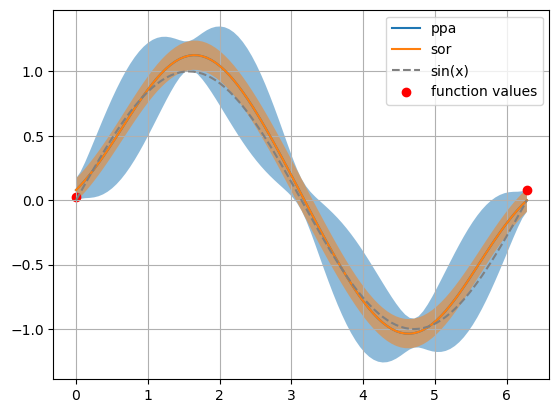

In [175]:
plt.plot(grid,means_ppa,label="ppa")
plt.fill_between(grid,means_ppa-stds_ppa,means_ppa+stds_ppa,alpha=0.5)
plt.plot(grid,means_sor,label="sor")
plt.fill_between(grid,means_sor-stds_sor,means_sor+stds_sor,alpha=0.5)
# plt.plot(grid,means_ny,label="ny")
# plt.fill_between(grid,means_ny-stds_ny,means_ny+stds_ny,alpha=0.5)
plt.plot(grid,func(grid),color="grey",ls="--",label="sin(x)")
plt.scatter(datagrid,data_values,color="r",label="function values")
plt.grid()
plt.legend()

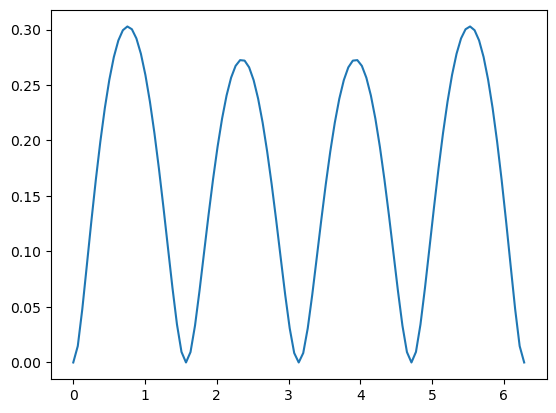

In [176]:
plt.plot(grid,stds_ppa-stds_sor)
# plt.plot(grid,stds_ppa-stds_ny)

## 2D case

In [177]:
key = random.PRNGKey(0)

def func(x1, x2,noise=0.0):
    return jnp.sin(2*x1 + x2) + noise*random.uniform(key, x1.shape)

def dx1_func(x1, x2, noise=0.0):
    return 2*jnp.cos(2*x1 + x2) + noise*random.uniform(key, x1.shape)

def dx2_func(x1, x2, noise=0.0):
    return jnp.cos(2*x1 + x2) + noise*random.uniform(key, x1.shape)

In [208]:
bounds_X1 = jnp.array([0.0, 2*jnp.pi])
bounds_X2 = jnp.array([0.0, 2*jnp.pi])

noise = 0.1

length_scale = 1.0

n_X1_data_points = 3
n_X2_data_points = 3
n_X1_dX1_points = 10
n_X2_dX1_points = 10
n_X1_dX2_points = 10
n_X2_dX2_points = 10

n_X1_ref_points = 10
n_X2_ref_points = 10

n_X1_grid_points = 101
n_X2_grid_points = 101

kernel = RBF()

In [210]:
# all the 1d grids for the according to the n_..._points above
X1_data_grid = jnp.linspace(*bounds_X1, n_X1_data_points)
X2_data_grid = jnp.linspace(*bounds_X2, n_X2_data_points)
X1_dX1_grid = jnp.linspace(*bounds_X1, n_X1_dX1_points)
X2_dX1_grid = jnp.linspace(*bounds_X2, n_X2_dX1_points)
X1_dX2_grid = jnp.linspace(*bounds_X1, n_X1_dX2_points)
X2_dX2_grid = jnp.linspace(*bounds_X2, n_X2_dX2_points)

X1_ref_grid = jnp.linspace(*bounds,n_X1_ref_points)
X2_ref_grid = jnp.linspace(*bounds,n_X2_ref_points)

X1_grid = jnp.linspace(*bounds,n_X1_grid_points)
X2_grid = jnp.linspace(*bounds,n_X2_grid_points)

# all 2d grids
data_grid = jnp.array(jnp.meshgrid(X1_data_grid,X2_data_grid)).reshape(2,-1).T
dX1_grid = jnp.array(jnp.meshgrid(X1_dX1_grid,X2_dX1_grid)).reshape(2,-1).T
dX2_grid = jnp.array(jnp.meshgrid(X1_dX2_grid,X2_dX2_grid)).reshape(2,-1).T

#all function values
data_values = func(data_grid[:,0], data_grid[:,1], noise)
dX1_values = dx1_func(dX1_grid[:,0], dX1_grid[:,1], noise)
dX2_values = dx2_func(dX2_grid[:,0], dX2_grid[:,1], noise)

# final data used for prediction
X_data = jnp.concatenate((data_grid, dX1_grid, dX2_grid))
Y_data = jnp.concatenate((data_values, dX1_values, dX2_values))

# reference grid for fitting and predicting
referencegrid = jnp.array(jnp.meshgrid(X1_ref_grid,X2_ref_grid)).reshape(2,-1).T
# grid on which the means and stds will be predicted
grid = jnp.array(jnp.meshgrid(X1_grid,X2_grid)).reshape(2,-1).T

In [209]:
print(data_grid.shape)
print(dX1_grid.shape)
print(dX2_grid.shape)
print(referencegrid.shape)
print(grid.shape)

(9, 2)
(100, 2)
(100, 2)
(100, 2)
(10201, 2)
